<a href="https://colab.research.google.com/github/jamesgiddingsott/eCars_eda/blob/main/electric_cars_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount

In [50]:
# from google.colab import drive
# # drive.mount('/drive')
# drive.mount("/drive", force_remount=True)

#Imports

In [51]:
! pip install xlsxwriter -q

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from time import sleep
from functools import reduce


#Scrape data

In [52]:
url = 'https://insideevs.com/reviews/344001/compare-evs/'


page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

dfs = pd.read_html(page.text)
print(len(dfs))


5


In [53]:
# for i in range(len(dfs)):
#   print("\n\nTable,", i, ":")
#   print(dfs[i].head(2))

In [54]:
# select only dfs user wants a few of the tables are not valid info for this analysis

dfs_select = dfs[:-2]
len(dfs_select)

3

In [55]:
def replace_headers_all_dfs(dfs):

  for i in range(len(dfs)):
    dfs[i].columns = dfs[i].loc[0]
    dfs[i] = dfs[i].loc[1:]
    dfs[i].reset_index(drop=True, inplace=True)

  return

In [56]:
replace_headers_all_dfs(dfs_select)
df_final = reduce(lambda left,right: pd.merge(left,right,on='Model', how='left'), dfs_select)
df_final.dropna(axis=1, how='all', inplace=True)
df_final.columns = df_final.columns.str.replace(r'_x$', '')
df_final.columns.str.strip()



Index(['Model', 'Base Price', 'Dest. Charge', 'Tax Credit', 'Effective Price',
       'Drive', 'Battery(kWh)', 'EPARange', '0-60mph(sec)', 'TopSpeed'],
      dtype='object', name=0)

In [57]:
df_final.head(2)

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed
0,2022 Audi e-tron GT quattro,"$99,900","+$1,045","$7,500","$93,445",AWD,93.4,238 mi*(383 km),3.9,152 mph(245 km/h)
1,2022 Audi RS e-tron GT quattro,"$139,900","+$1,045","$7,500","$133,445",AWD,93.4,232 mi*(373 km),3.1,155 mph(249 km/h)


In [58]:
df = df_final.copy()

#Data Wrangling

In [59]:
df['make'] = df['Model'].str.split(' ').str[1]
df['simple_model'] = (df['Model'].str.split(' ').str[2:])
df['simple_model'] = df['simple_model'].str.join(' ')
# type(df['Model'].str.split(' ').str[1])
df[df['make']=='Hyundai']

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model
21,"2022 Hyundai Ioniq 5 SE RWD (19"")",NaN,NaN,"$7,500",NaN,RWD,77.4,300 mi*(483 km),NaN,115 mph(0 km/h),Hyundai,"Ioniq 5 SE RWD (19"")"
22,"2022 Hyundai Ioniq 5 SE AWD (19"")",NaN,NaN,"$7,500",NaN,AWD,77.4,269 mi*(433 km),5.0,115 mph(0 km/h),Hyundai,"Ioniq 5 SE AWD (19"")"
23,"2022 Hyundai Ioniq 5 Limited AWD (20"")",NaN,NaN,"$7,500",NaN,AWD,77.4,244 mi*(393 km),5.0,115 mph(0 km/h),Hyundai,"Ioniq 5 Limited AWD (20"")"
24,2021 Hyundai IONIQ Electric,"$33,245","+$1,005","$7,500","$26,750",FWD,38.3,170 mi(274 km),10.0,102 mph(164 km/h),Hyundai,IONIQ Electric
25,2022 Hyundai Kona Electric,"$34,000","+$1,185","$7,500","$27,685",FWD,64,258 mi(415 km),7.9,104 mph(167 km/h),Hyundai,Kona Electric


In [60]:
df['Battery(kWh)'] = (df['Battery(kWh)'].str.replace('*',''))
df['Battery(kWh)'] = pd.to_numeric(df['Battery(kWh)'], errors='raise')
(df[df['make'] == 'Tesla' ])
# df.dtypes

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model
56,2021 Tesla Model 3 Standard Range Plus,"$43,990","+$1,200",NaN,"$45,190",RWD,60.0,262 mi*(422 km),5.3,140 mph(225 km/h),Tesla,Model 3 Standard Range Plus
57,2021 Tesla Model 3 Long Range AWD,"$49,990","+$1,200",NaN,"$51,190",AWD,80.0,353 mi(568 km),4.2,145 mph(233 km/h),Tesla,Model 3 Long Range AWD
58,"2021 Tesla Model 3 Perf. LR AWD 20""","$57,990","+$1,200",NaN,"$59,190",AWD,80.0,315 mi(507 km),3.1,162 mph(261 km/h),Tesla,"Model 3 Perf. LR AWD 20"""
59,"2021 Tesla Model S Long Range (AWD) 19""","$94,990","+$1,200",NaN,"$96,190",AWD,100.0,405 mi(652 km),3.1,155 mph(249 km/h),Tesla,"Model S Long Range (AWD) 19"""
60,"2021 Tesla Model S Plaid 19""","$129,990","+$1,200",NaN,"$131,190",AWD,100.0,396 mi*(637 km),1.99*,200 mph(322 km/h),Tesla,"Model S Plaid 19"""
61,"2021 Tesla Model S Plaid 21""","$134,490","+$1,200",NaN,"$135,690",AWD,100.0,348 mi(560 km),1.99*,200 mph(322 km/h),Tesla,"Model S Plaid 21"""
62,"2021 Tesla Model X Long Range (AWD) 20""","$104,990","+$1,200",NaN,"$106,190",AWD,100.0,360 mi*(579 km),3.8,155 mph(249 km/h),Tesla,"Model X Long Range (AWD) 20"""
63,"2021 Tesla Model X Plaid 20""","$119,990","+$1,200",NaN,"$121,190",AWD,100.0,340 mi*(547 km),2.5,163 mph(262 km/h),Tesla,"Model X Plaid 20"""
64,"2021 Tesla Model Y Long Range AWD 19""","$56,990","+$1,200",NaN,"$58,190",AWD,80.0,326 mi(525 km),4.8,135 mph(217 km/h),Tesla,"Model Y Long Range AWD 19"""
65,"2021 Tesla Model Y Perf. LR AWD 21""","$61,990","+$1,200",NaN,"$63,190",AWD,80.0,303 mi(488 km),3.5,155 mph(249 km/h),Tesla,"Model Y Perf. LR AWD 21"""


In [61]:
df[['EPARange_mi', 'EPARange_km']] = df['EPARange'].str.split('(', expand=True)

df['EPARange_mi'] = df['EPARange_mi'].str.split(' ').str[0]
df['EPARange_mi'] = pd.to_numeric(df['EPARange_mi'], errors='coerce').fillna(0).astype(int)

df['EPARange_km'] = df['EPARange_km'].str.split(' ').str[0]
df['EPARange_km'] = pd.to_numeric(df['EPARange_km'], errors='coerce').fillna(0).astype(int)


df[['EPARange_mi', 'EPARange_km']] = df['EPARange'].str.split('(', expand=True)



df.head(2)

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model,EPARange_mi,EPARange_km
0,2022 Audi e-tron GT quattro,"$99,900","+$1,045","$7,500","$93,445",AWD,93.4,238 mi*(383 km),3.9,152 mph(245 km/h),Audi,e-tron GT quattro,238 mi*,383 km)
1,2022 Audi RS e-tron GT quattro,"$139,900","+$1,045","$7,500","$133,445",AWD,93.4,232 mi*(373 km),3.1,155 mph(249 km/h),Audi,RS e-tron GT quattro,232 mi*,373 km)


In [62]:
def split_units(df,new_cols, base_column, delimiter):
  
  df[new_cols] = df[base_column].str.split(delimiter, expand=True)

  df[new_cols[0]] = df[new_cols[0]].str.split(' ').str[0]
  df[new_cols[0]] = df[new_cols[0]].str.replace('*','')
  df[new_cols[0]] = pd.to_numeric(df[new_cols[0]], errors='coerce').fillna(0).astype(int)

  df[new_cols[1]] = df[new_cols[1]].str.split(' ').str[0]
  df[new_cols[1]] = df[new_cols[1]].str.replace('*','')
  df[new_cols[1]] = pd.to_numeric(df[new_cols[1]], errors='coerce').fillna(0).astype(int)

  return df

In [63]:
df_blue = df.copy()
df_blue = split_units(df_blue,['epa_mi', 'epa_km'], 'EPARange', '(' )
df_blue = split_units(df_blue,['top_speed_mi', 'top_speed_km'], 'TopSpeed', '(' )
df_blue

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model,EPARange_mi,EPARange_km,epa_mi,epa_km,top_speed_mi,top_speed_km
0,2022 Audi e-tron GT quattro,"$99,900","+$1,045","$7,500","$93,445",AWD,93.4,238 mi*(383 km),3.9,152 mph(245 km/h),Audi,e-tron GT quattro,238 mi*,383 km),238,383,152,245
1,2022 Audi RS e-tron GT quattro,"$139,900","+$1,045","$7,500","$133,445",AWD,93.4,232 mi*(373 km),3.1,155 mph(249 km/h),Audi,RS e-tron GT quattro,232 mi*,373 km),232,373,155,249
2,2021 Audi e-tron,"$65,900","+$1,095","$7,500","$59,495",AWD,95.0,222 mi(357 km),5.5,124 mph(200 km/h),Audi,e-tron,222 mi,357 km),222,357,124,200
3,2021 Audi e-tron Sportback,"$69,100","+$1,095","$7,500","$62,695",AWD,95.0,218 mi(351 km),5.5,124 mph(200 km/h),Audi,e-tron Sportback,218 mi,351 km),218,351,124,200
4,"2022 Audi e-tron S 20""","$84,800","+$1,095","$7,500","$78,395",AWD,95.0,208 mi(335 km),4.3,130 mph(209 km/h),Audi,"e-tron S 20""",208 mi,335 km),208,335,130,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022 Volvo XC40 Recharge,"$55,300","+$1,095","$7,500","$48,895",AWD,78.0,223 mi(359 km),4.7,112 mph(180 km/h),Volvo,XC40 Recharge,223 mi,359 km),223,359,112,180
68,"2021 Volkswagen ID.4 Pro (19"")","$39,995","+$1,195","$7,500","$33,690",RWD,82.0,260 mi(418 km),NaN,NaN,Volkswagen,"ID.4 Pro (19"")",260 mi,418 km),260,418,0,0
69,"2021 Volkswagen ID.4 Pro S (19"")","$44,495","+$1,195","$7,500","$38,190",RWD,82.0,250 mi(402 km),NaN,NaN,Volkswagen,"ID.4 Pro S (19"")",250 mi,402 km),250,402,0,0
70,"2021 Volkswagen ID.4 AWD Pro (19"")","$43,675","+$1,195","$7,500","$37,370",AWD,82.0,249 mi(401 km),5.7,NaN,Volkswagen,"ID.4 AWD Pro (19"")",249 mi,401 km),249,401,0,0


In [64]:
df = df_blue.copy()
df['Battery(kWh)'] = pd.to_numeric( df['Battery(kWh)'] ,errors='coerce').fillna(0).astype(int)
df['wh/mi'] = round((df['Battery(kWh)'] * 1000) / df['epa_mi']).fillna(0)
df.head()
len(df)

72

In [65]:
df['Effective Price'] = df['Effective Price'].replace('[\$,]', '', regex=True).astype(float)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['EPARange'].dropna(axis=0,how='any', inplace=True)
df['Tax Credit'].fillna(0, inplace=True)
df['Effective Price'] = pd.to_numeric(df['Effective Price'], errors='raise').fillna(0)
df['real_range'] = df['epa_mi'] *.7
len(df)

72

In [66]:
df.sort_values('wh/mi', ascending=True)

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model,EPARange_mi,EPARange_km,epa_mi,epa_km,top_speed_mi,top_speed_km,wh/mi,real_range
32,"2022 Lucid Air Grand Touring (19"")","$139,000","+$1,500","$7,500",133000.0,AWD,112,516 mi(830 km),3.0,168 mph(270 km/h),Lucid,"Air Grand Touring (19"")",516 mi,830 km),516,830,168,270,217.0,361.2
24,2021 Hyundai IONIQ Electric,"$33,245","+$1,005","$7,500",26750.0,FWD,38,170 mi(274 km),10.0,102 mph(164 km/h),Hyundai,IONIQ Electric,170 mi,274 km),170,274,102,164,224.0,119.0
57,2021 Tesla Model 3 Long Range AWD,"$49,990","+$1,200",0,51190.0,AWD,80,353 mi(568 km),4.2,145 mph(233 km/h),Tesla,Model 3 Long Range AWD,353 mi,568 km),353,568,145,233,227.0,247.1
30,"2022 Lucid Air Dream Edition Range (19"")","$169,000","+$1,500","$7,500",163000.0,AWD,118,520 mi(837 km),2.7,168 mph(270 km/h),Lucid,"Air Dream Edition Range (19"")",520 mi,837 km),520,837,168,270,227.0,364.0
56,2021 Tesla Model 3 Standard Range Plus,"$43,990","+$1,200",0,45190.0,RWD,60,262 mi*(422 km),5.3,140 mph(225 km/h),Tesla,Model 3 Standard Range Plus,262 mi*,422 km),262,422,140,225,229.0,183.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,2021 Porsche Taycan Turbo Cross Turismo,"$153,500","+$1,350","$7,500",147350.0,AWD,93,204 mi(328 km),3.1,155 mph(250 km/h),Porsche,Taycan Turbo Cross Turismo,204 mi,328 km),204,328,155,250,456.0,142.8
4,"2022 Audi e-tron S 20""","$84,800","+$1,095","$7,500",78395.0,AWD,95,208 mi(335 km),4.3,130 mph(209 km/h),Audi,"e-tron S 20""",208 mi,335 km),208,335,130,209,457.0,145.6
52,2021 Porsche Taycan Turbo S Cross Turismo,"$187,600","+$1,350","$7,500",181450.0,AWD,93,202 mi(325 km),2.7,155 mph(250 km/h),Porsche,Taycan Turbo S Cross Turismo,202 mi,325 km),202,325,155,250,460.0,141.4
48,2021 Porsche Taycan Turbo S (93 kWh),"$185,000","+$1,350","$7,500",178850.0,AWD,93,201 mi(323 km),2.6,161 mph(259 km/h),Porsche,Taycan Turbo S (93 kWh),201 mi,323 km),201,323,161,259,463.0,140.7


##Simple Charts

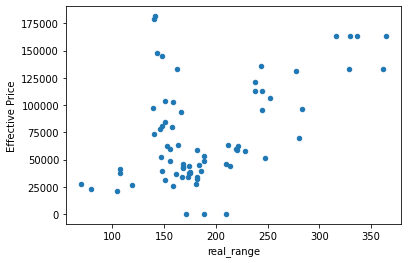

In [67]:
df.plot.scatter(x='real_range', y='Effective Price')

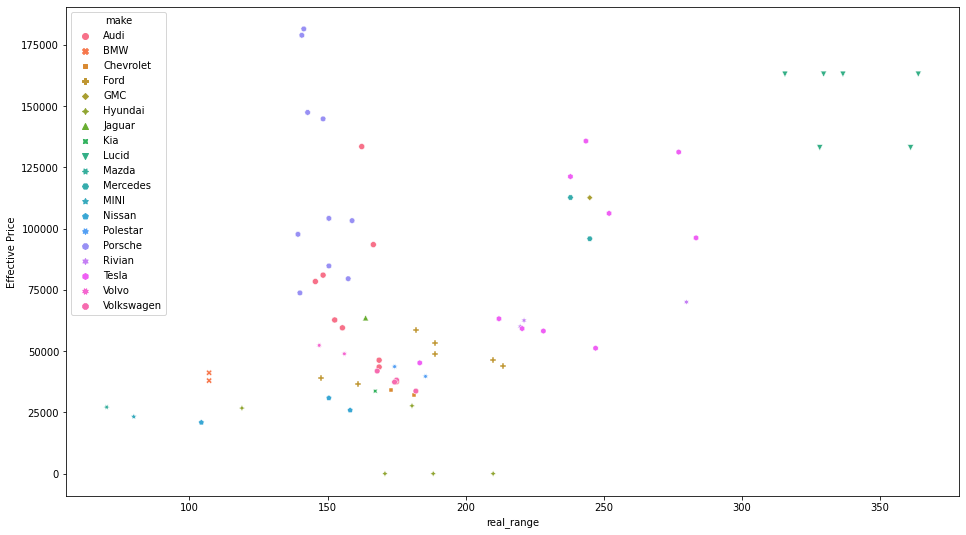

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(figsize=(16,9))
sns.scatterplot(data=df,x='real_range',y='Effective Price', hue='make', style='make')

(0.0, 75000.0)

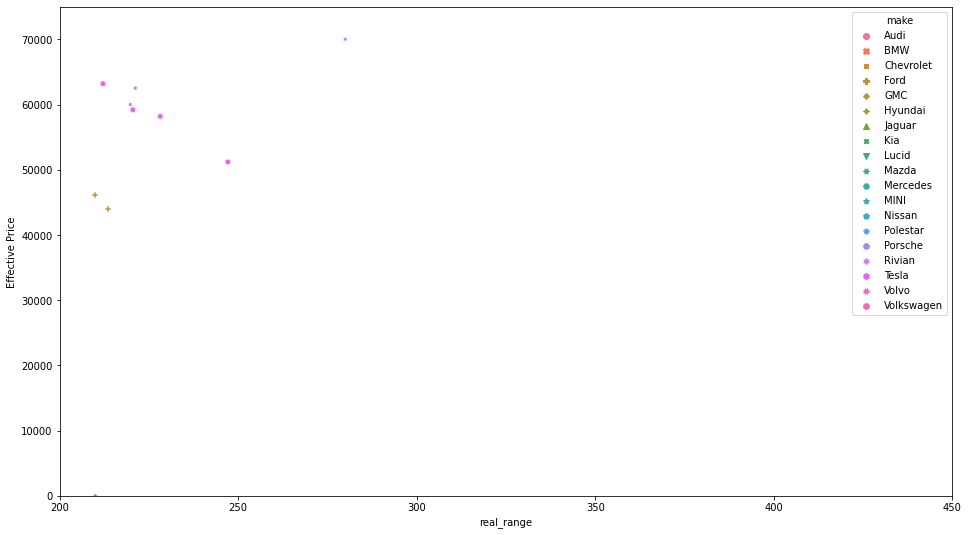

In [69]:
fig,ax = plt.subplots(figsize=(16,9))
sns.scatterplot(data=df,x='real_range',y='Effective Price', hue='make', style='make')
ax.set_xlim(200, 450)
ax.set_ylim(0, 75000)

In [70]:
# df = df[df['Effective Price'] < 77000]
df = df[df['Effective Price'] > 0]
df = df[df['epa_mi'] > 0]
df = df[df['real_range'] > 0]

In [71]:
import plotly.express as px

fig = px.scatter(df, x='real_range', y='Effective Price', color='make', hover_data=['simple_model'])
fig.show()

In [72]:
# from sklearn.cluster import KMeans

# df_cluster = df.copy()



# kmeans = KMeans(n_clusters=5).fit(df_cluster[['epa_mi','Effective Price']])
# centroids = kmeans.cluster_centers_
# centroids

## Top 10, subset

In [73]:
# Real Range 150+ and no RWD only models...TOP TEN CARS LEFT


df['$/mi_range'] = df['Effective Price'] / df['real_range']

df_top10 = df.copy()
df_top10 = df_top10.sort_values('$/mi_range')
df_top10 = df_top10[df_top10['real_range'] > 150]
df_top10 = df_top10[df_top10['Drive'] != 'RWD']
df_top10.head(10)

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model,EPARange_mi,EPARange_km,epa_mi,epa_km,top_speed_mi,top_speed_km,wh/mi,real_range,$/mi_range
25,2022 Hyundai Kona Electric,"$34,000","+$1,185","$7,500",27685.0,FWD,64,258 mi(415 km),7.9,104 mph(167 km/h),Hyundai,Kona Electric,258 mi,415 km),258,415,104,167,248.0,180.6,153.294574
39,2022 Nissan LEAF e+ S (62 kWh),"$32,400",+$975,"$7,500",25875.0,FWD,62,226 mi(364 km),6.5*,NaN,Nissan,LEAF e+ S (62 kWh),226 mi,364 km),226,364,0,0,274.0,158.2,163.558786
11,2022 Chevrolet Bolt EV,"$31,000",+$995,0,31995.0,FWD,65,259 mi(417 km),6.5*,NaN,Chevrolet,Bolt EV,259 mi,417 km),259,417,0,0,251.0,181.3,176.475455
12,2022 Chevrolet Bolt EUV,"$33,000",+$995,0,33995.0,FWD,65,247 mi(397 km),7.0*,NaN,Chevrolet,Bolt EUV,247 mi,397 km),247,397,0,0,263.0,172.9,196.616541
27,2022 Kia Niro EV (e-Niro),"$39,990","+$1,175","$7,500",33665.0,FWD,64,239 mi(385 km),7.5,104 mph(167 km/h),Kia,Niro EV (e-Niro),239 mi,385 km),239,385,104,167,268.0,167.3,201.225344
40,2022 Nissan LEAF e+ SV (62 kWh),"$37,400",+$975,"$7,500",30875.0,FWD,62,215 mi(346 km),6.5*,NaN,Nissan,LEAF e+ SV (62 kWh),215 mi,346 km),215,346,0,0,288.0,150.5,205.149502
57,2021 Tesla Model 3 Long Range AWD,"$49,990","+$1,200",0,51190.0,AWD,80,353 mi(568 km),4.2,145 mph(233 km/h),Tesla,Model 3 Long Range AWD,353 mi,568 km),353,568,145,233,227.0,247.1,207.163092
41,"2022 Polestar 2 Single Motor 19""","$45,900","+$1,300","$7,500",39700.0,FWD,78,265 mi*(426 km),7.0,100 mph(161 km/h),Polestar,"2 Single Motor 19""",265 mi*,426 km),265,426,100,161,294.0,185.5,214.016173
70,"2021 Volkswagen ID.4 AWD Pro (19"")","$43,675","+$1,195","$7,500",37370.0,AWD,82,249 mi(401 km),5.7,NaN,Volkswagen,"ID.4 AWD Pro (19"")",249 mi,401 km),249,401,0,0,329.0,174.3,214.400459
71,"2021 Volkswagen ID.4 AWD Pro S (19"")","$48,175","+$1,195","$7,500",41870.0,AWD,82,240 mi(386 km),NaN,NaN,Volkswagen,"ID.4 AWD Pro S (19"")",240 mi,386 km),240,386,0,0,342.0,168.0,249.226190


In [74]:
df

,Model,Base Price,Dest. Charge,Tax Credit,Effective Price,Drive,Battery(kWh),EPARange,0-60mph(sec),TopSpeed,make,simple_model,EPARange_mi,EPARange_km,epa_mi,epa_km,top_speed_mi,top_speed_km,wh/mi,real_range,$/mi_range
0,2022 Audi e-tron GT quattro,"$99,900","+$1,045","$7,500",93445.0,AWD,93,238 mi*(383 km),3.9,152 mph(245 km/h),Audi,e-tron GT quattro,238 mi*,383 km),238,383,152,245,391.0,166.6,560.894358
1,2022 Audi RS e-tron GT quattro,"$139,900","+$1,045","$7,500",133445.0,AWD,93,232 mi*(373 km),3.1,155 mph(249 km/h),Audi,RS e-tron GT quattro,232 mi*,373 km),232,373,155,249,401.0,162.4,821.705665
2,2021 Audi e-tron,"$65,900","+$1,095","$7,500",59495.0,AWD,95,222 mi(357 km),5.5,124 mph(200 km/h),Audi,e-tron,222 mi,357 km),222,357,124,200,428.0,155.4,382.850708
3,2021 Audi e-tron Sportback,"$69,100","+$1,095","$7,500",62695.0,AWD,95,218 mi(351 km),5.5,124 mph(200 km/h),Audi,e-tron Sportback,218 mi,351 km),218,351,124,200,436.0,152.6,410.845347
4,"2022 Audi e-tron S 20""","$84,800","+$1,095","$7,500",78395.0,AWD,95,208 mi(335 km),4.3,130 mph(209 km/h),Audi,"e-tron S 20""",208 mi,335 km),208,335,130,209,457.0,145.6,538.427198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022 Volvo XC40 Recharge,"$55,300","+$1,095","$7,500",48895.0,AWD,78,223 mi(359 km),4.7,112 mph(180 km/h),Volvo,XC40 Recharge,223 mi,359 km),223,359,112,180,350.0,156.1,313.228700
68,"2021 Volkswagen ID.4 Pro (19"")","$39,995","+$1,195","$7,500",33690.0,RWD,82,260 mi(418 km),NaN,NaN,Volkswagen,"ID.4 Pro (19"")",260 mi,418 km),260,418,0,0,315.0,182.0,185.109890
69,"2021 Volkswagen ID.4 Pro S (19"")","$44,495","+$1,195","$7,500",38190.0,RWD,82,250 mi(402 km),NaN,NaN,Volkswagen,"ID.4 Pro S (19"")",250 mi,402 km),250,402,0,0,328.0,175.0,218.228571
70,"2021 Volkswagen ID.4 AWD Pro (19"")","$43,675","+$1,195","$7,500",37370.0,AWD,82,249 mi(401 km),5.7,NaN,Volkswagen,"ID.4 AWD Pro (19"")",249 mi,401 km),249,401,0,0,329.0,174.3,214.400459


# Scrape Avg State Gasoline Price

In [75]:

# Set user agent to bypass 403 error on scraping

state_code = 'TX'

url_gasoline = 'https://gasprices.aaa.com/?state={}'.format(state_code)


user_agent = "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.37"
url = url_gasoline
data = requests.get(url, headers={'User-Agent': user_agent})
code = BeautifulSoup(data.text, 'html.parser')



# Make a GET request to fetch the raw HTML content
page = requests.get(url).text
page = requests.get(url, headers={'User-Agent': user_agent}).text

# # Parse the html content
soup = BeautifulSoup(page, "lxml")

# All tables to list
dfs_gasoline_all = pd.read_html(page)
# print(len(dfs_gasoline))

# Grab first table, first gas price needed
df_gasoline = dfs_gasoline_all[0]
gas_price = float(df_gasoline['Regular'][0].replace('$',''))
gas_price

3.051

In [76]:
# import xlsxwriter

# file_path = '/content/drive/MyDrive/electric_cars/'
# file_name = 'electric_cars_data.xlsx'

# writer = pd.ExcelWriter('/drive/My Drive/eCars_V1.xlsx', engine='xlsxwriter')

# df.to_excel(writer, sheet_name='raw_data_modified')

# df_top10.to_excel(writer, sheet_name='Top_10')

# # #df3.to_excel(writer, sheet_name='Sheetc')

# writer.save()
# df.to_csv('/drive/My Drive/eCars.csv')

# SET ASSUMPTIONS:  Costs to charge

In [77]:

residential_per_kWh = .14
supercharger_per_kWh = .28  # avg of researched prices:  https://www.myev.com/research/ev-101/what-it-costs-to-charge-an-electric-vehicle

L2_home_charger = 2000.0  # Costs for installation in home
mean_mi_per_year = 12000  # Avg miles driven per year
amortorized_L2_charger_period_yrs = 3

avg_mpg = 25  # Avg fuel efficiency of U.S. vehicle


## costs to table

In [78]:
df['home_charge_cost_batt'] = df['Battery(kWh)'] *  residential_per_kWh
df['home_cost_real_mi'] = df['home_charge_cost_batt'] / df['real_range']
df['L2_home_cost_real_mi'] = ((L2_home_charger / mean_mi_per_year) / amortorized_L2_charger_period_yrs) + df['home_cost_real_mi']

df['supercharger_cost_batt'] = df['Battery(kWh)'] *  supercharger_per_kWh
df['supercharger_cost_real_mi'] = df['supercharger_cost_batt'] / df['real_range']

# df[df['make'] == 'Tesla']

df['gas_car_per_mi_cost'] = gas_price / avg_mpg

In [79]:
df['L2_home_vs_gas'] = df['L2_home_cost_real_mi'] - df['gas_car_per_mi_cost']

In [80]:
df[df['make'] == 'Tesla']

# df[df['simple_model'] == '2021 Tesla Model X Long Range (AWD) 20"']

df.loc[57]

0
Model                        2021 Tesla Model 3 Long Range AWD
Base Price                                             $49,990
Dest. Charge                                           +$1,200
Tax Credit                                                   0
Effective Price                                          51190
Drive                                                      AWD
Battery(kWh)                                                80
EPARange                                        353 mi(568 km)
0-60mph(sec)                                               4.2
TopSpeed                                     145 mph(233 km/h)
make                                                     Tesla
simple_model                            Model 3 Long Range AWD
EPARange_mi                                             353 mi
EPARange_km                                            568 km)
epa_mi                                                     353
epa_km                                               

## Top Ten based on L2 Home Charging vs Gasoline

In [88]:
df_top10 = df.copy()
df_top10 = df_top10[df_top10['Effective Price'] < 75000]
df_top10 = df_top10.sort_values('L2_home_vs_gas')
df_top10 = df_top10[df_top10['real_range'] > 150]
df_top10 = df_top10[df_top10['Drive'] != 'RWD']
df_top10 = df_top10[['Model', 'Tax Credit', 'Effective Price', 'real_range', 'home_charge_cost_batt', 'supercharger_cost_batt', 'home_cost_real_mi', 'L2_home_cost_real_mi', 'gas_car_per_mi_cost', 'L2_home_vs_gas' ]]
df_top10.head(10)

,Model,Tax Credit,Effective Price,real_range,home_charge_cost_batt,supercharger_cost_batt,home_cost_real_mi,L2_home_cost_real_mi,gas_car_per_mi_cost,L2_home_vs_gas
57,2021 Tesla Model 3 Long Range AWD,0,51190.0,247.1,11.20,22.40,0.045326,0.100881,0.12204,-0.021159
64,"2021 Tesla Model Y Long Range AWD 19""",0,58190.0,228.2,11.20,22.40,0.049080,0.104635,0.12204,-0.017405
25,2022 Hyundai Kona Electric,"$7,500",27685.0,180.6,8.96,17.92,0.049612,0.105168,0.12204,-0.016872
11,2022 Chevrolet Bolt EV,0,31995.0,181.3,9.10,18.20,0.050193,0.105749,0.12204,-0.016291
58,"2021 Tesla Model 3 Perf. LR AWD 20""",0,59190.0,220.5,11.20,22.40,0.050794,0.106349,0.12204,-0.015691
12,2022 Chevrolet Bolt EUV,0,33995.0,172.9,9.10,18.20,0.052632,0.108187,0.12204,-0.013853
65,"2021 Tesla Model Y Perf. LR AWD 21""",0,63190.0,212.1,11.20,22.40,0.052805,0.108361,0.12204,-0.013679
27,2022 Kia Niro EV (e-Niro),"$7,500",33665.0,167.3,8.96,17.92,0.053556,0.109112,0.12204,-0.012928
39,2022 Nissan LEAF e+ S (62 kWh),"$7,500",25875.0,158.2,8.68,17.36,0.054867,0.110423,0.12204,-0.011617
40,2022 Nissan LEAF e+ SV (62 kWh),"$7,500",30875.0,150.5,8.68,17.36,0.057674,0.113230,0.12204,-0.008810


#Save to CSV

In [82]:
# df.to_csv('/drive/My Drive/eCars.csv')


# import xlsxwriter

# file_path = '/content/drive/MyDrive/electric_cars/'
# file_name = 'electric_cars_data.xlsx'

# writer = pd.ExcelWriter('/drive/My Drive/eCars_V1.xlsx', engine='xlsxwriter')

# df.to_excel(writer, sheet_name='raw_data_modified')

# df_top10.to_excel(writer, sheet_name='Top_10')

# # #df3.to_excel(writer, sheet_name='Sheetc')

# writer.save()